# CycleGAN: toy example
This is an toy example that applies importance sampling to CycleGAN.


*   Adds the weight network that is trained with G nand D
*   Modifies G and D losses by multiplying by w/w*



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import itertools

import matplotlib.pyplot as plt

### Functions for generation and visualization of the image batches

In [2]:
def visualize_img_batch(batch):
    '''Visualizes image batch
    
    Parameters:
    batch (Tensor): An image batch
    '''
    grid = make_grid(batch, nrow=8, padding=1, normalize=False, range=None, scale_each=False, pad_value=0)
    plt.imshow(grid.permute(1,2,0))
    plt.show()

In [3]:
def random_image_data(size=(2**21, 3, 1, 1), ratio=0.5, offset=0.2, color=0):
    '''Generates a random image batch 
    consisting of two modes (dark and light images)
    
    Parameters:
    size (tuple): The dimensions of the image batch (batch_size, channels, width, length)
    ratio (float): The ratio of light to dark images
    offset (float): The brightness of the images relative to black and bright
    color (int): Red = 0, green = 1, blue = 2
    
    Returns:
    image_batch (Tensor): The generated image batch
    
    '''
    idx = torch.randperm(size[0])[:int(ratio*size[0])] # Randomly choose indices according to the ratio
    image_batch = torch.zeros(size)
    image_batch[:, color] += offset # light color
    image_batch[idx, color] = 1 - offset # dark color 
    return image_batch

### The dataset class

In [4]:
class ColorDataset(Dataset):
    '''The dataloader for the color images
    '''
    def __init__(self, ratio=0.5, offset=0.2, color=0):
        '''  
        Parameters:
        ratio (float): The ratio of light to dark images
        offset (float): The brightness of the images relative to black and bright
        color (int): Red = 0, green = 1, blue = 2
        '''
        self.offset = offset
        self.ratio = ratio
        self.color = color
        
        self.dataset = random_image_data(ratio=self.ratio, 
                                         offset=self.offset, 
                                         color=self.color)
        self.example_imgs = self.example()
        
    def example(self):
        '''
        Returns an example from each mode in the domain
        
        '''
        example_imgs = torch.zeros(size=(2, 3, 1, 1))

        example_imgs[0, self.color] += self.offset # light color
        example_imgs[1, self.color] = 1 - self.offset # dark color
        return example_imgs   

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]

### The networks

In [5]:
class Discriminator(nn.Module):
    '''A simple joint discriminator network'''

    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 1)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x.view(-1, 3)))
        out = torch.sigmoid(self.fc2(h1))
        return out

In [6]:
class Generator(nn.Module):
    '''A simple conditional generator network'''

    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 3)
        
    def forward(self, x):
        h1 = F.relu(self.fc1(x.view(-1, 3)))
        out = torch.sigmoid(self.fc2(h1))
        return out.unsqueeze(-1).unsqueeze(-1)

In [7]:
class TrivialWeightNet(nn.Module):
    '''A trivial network that predicts the importances of the samples'''

    def __init__(self):
        super(TrivialWeightNet, self).__init__()
        self.fc1 = nn.Linear(1, 1)
        
    def forward(self, x):
        out = torch.ones((x.size()[0], 1))
        out /= out.sum()
        return out

In [8]:
class WeightNet(nn.Module):
    '''A simple network that predicts the importances of the samples'''

    def __init__(self):
        super(WeightNet, self).__init__()
        self.fc1 = nn.Linear(3, 1)
        self.fc2 = nn.Linear(1, 1)
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x.view(-1, 3)))
        out = self.softmax(self.fc2(h1))
        return out

### A demonstration of the two domains
The idea here is that we create two domains: A red and a green domain. The domains consist of two modes: dark and light images. The big assumption here for our purpose is that the dark and light images have semantic correspondance, so for example: dark red will be translated to dark green.

We can adjust the intensity of the images (offset) and the ratio of the modes for the experiment. In the visualiztion you can see the elements of the dataset. In the histogram you can see the modes.

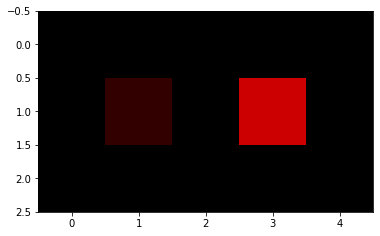

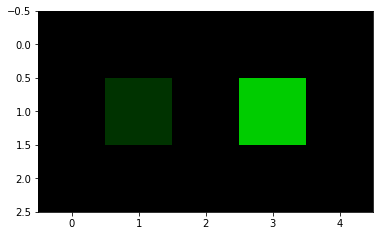

In [9]:
# Settings for domain A (red)
offset_A = 0.2
ratio_A = 0.5
color_A = 0
dataset_A = ColorDataset(offset=offset_A, ratio=ratio_A, color=color_A)
dataloader_A = DataLoader(dataset_A, batch_size=256, shuffle=True)

# Settings for domain B (green)
offset_B = 0.2
ratio_B = 0.5
color_B = 1
dataset_B = ColorDataset(offset=offset_B, ratio=ratio_B, color=color_B)
dataloader_B = DataLoader(dataset_B, batch_size=256, shuffle=True)

visualize_img_batch(dataset_A.example_imgs)
visualize_img_batch(dataset_B.example_imgs)

True ratio domain A: 0.5
Count: tensor([132, 124]) Ratio in this batch: tensor([0.5156, 0.4844])


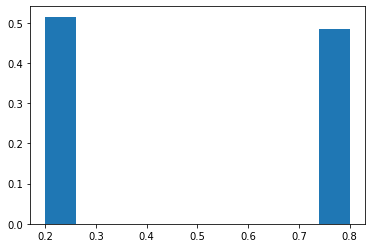

True ratio domain B: 0.5
Count: tensor([125, 131]) Ratio in this batch: tensor([0.4883, 0.5117])


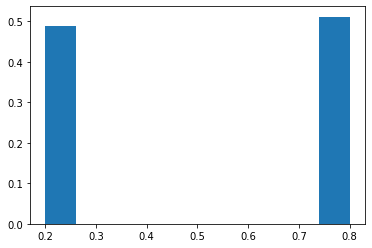

In [10]:
def plot_hist(data):
    data = data.view(3, -1).sum(0)
    plt.hist(data, weights=torch.ones(len(data))/len(data))
    x_unique_count = torch.stack([(data==x_u).sum() for x_u in data.unique()])
    
    print('Count:', x_unique_count, 'Ratio in this batch:', x_unique_count/float(x_unique_count.sum()))

    plt.show()

for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
    print('True ratio domain A:', dataloader_A.dataset.ratio)
    plot_hist(data_A)
    print('True ratio domain B:', dataloader_B.dataset.ratio)
    plot_hist(data_B)
    break

## The training loop

In [11]:
# Initialize the networks
generator_A = Generator()
generator_B = Generator()
discriminator_A = Discriminator()
discriminator_B = Discriminator()
weight_network_A = WeightNet()
weight_network_B = WeightNet()

# Initialize the optimizers
optimizer_g = optim.Adam(itertools.chain(generator_A.parameters(),
                                         generator_B.parameters()), lr=0.01)
optimizer_d = optim.Adam(itertools.chain(discriminator_A.parameters(),
                                         discriminator_B.parameters()), lr=0.01)
optimizer_w = optim.Adam(itertools.chain(weight_network_A.parameters(), 
                                         weight_network_B.parameters()), lr=0.01)

# Store values
samples_A = []
samples_B = []

losses_g = []
losses_d = []
losses_w = []

Lminusses = []
Lplusses = []

example_importances_A = []
example_importances_B = []

criterion_D = nn.MSELoss()
criterion_G = nn.MSELoss()
criterion_cycle = nn.MSELoss()
criterion_L2 = nn.MSELoss()

sampled_batch_size = 64 # The amount of images sampled using importance sampling

for epoch in range(1):
    for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
        # Set gradients to zero
        optimizer_d.zero_grad()
        optimizer_g.zero_grad()
        optimizer_w.zero_grad()

         # The sampling process ----------------------------------------------------------------------------
        importances_A = weight_network_A(data_A).squeeze() # Get the importances for each image in domain A
        importances_B = weight_network_B(data_B).squeeze() # Get the importances for each image in domain B

        sampled_idx_A = list( # Sample from batch A according to these importances
            torch.utils.data.sampler.WeightedRandomSampler(importances_A, 
                                                           sampled_batch_size, 
                                                           replacement=False))

        sampled_importances_A = importances_A[sampled_idx_A] # The importances assigned to the smaller batch
        real_A = data_A[sampled_idx_A] # The sampled smaller batch A

        sampled_idx_B = list( # Sample from batch Baccording to these importances
            torch.utils.data.sampler.WeightedRandomSampler(importances_B,
                                                           sampled_batch_size, 
                                                           replacement=False))

        sampled_importances_B = importances_B[sampled_idx_B] # The importances assigned to the smaller batch
        real_B = data_B[sampled_idx_B] # The sampled smaller batch B
        # --------------------------------------------------------------------------------------------------

        # Forward
        fake_A = generator_A(real_B)
        fake_B = generator_B(real_A)
        
        rec_A = generator_A(fake_B)
        rec_B = generator_B(fake_A)
        
        pred_real_A = discriminator_A(real_A)
        pred_real_B = discriminator_B(real_B)
        
        pred_fake_A = discriminator_A(fake_A.detach())
        pred_fake_B = discriminator_B(fake_B.detach())
        
        # The loss function --------------------------------------------------------------------------------
        loss_D_real_A = criterion_D(pred_real_A, torch.ones((pred_real_A.shape)))
        loss_D_real_B = criterion_D(pred_real_B, torch.ones((pred_real_B.shape)))

        loss_D_fake_A = criterion_D(pred_fake_A, torch.zeros((pred_fake_A.shape)))
        loss_D_fake_B = criterion_D(pred_fake_B, torch.zeros((pred_fake_B.shape)))
        
        loss_D_A = (((loss_D_real_A + loss_D_fake_A) * 0.5) )
        loss_D_B = (((loss_D_real_B + loss_D_fake_B) * 0.5) )
        
        loss_G_A = (criterion_G(discriminator_A(fake_A), torch.ones((pred_fake_A.shape))) )
        loss_G_B = (criterion_G(discriminator_B(fake_B), torch.ones((pred_fake_A.shape))) )
        
        cycle_A = (criterion_cycle(real_A, rec_A) )
        cycle_B = (criterion_cycle(real_B, rec_B) )
        cycle = cycle_A + cycle_B
        
        loss_d = (loss_D_A + loss_D_B)
        loss_g = (loss_G_A + loss_G_B) + cycle

        #Loss for the weight network
        Lmin = (pred_fake_B.detach() * sampled_importances_A/sampled_importances_A.detach()).sum()
        Lplus = (pred_fake_A.detach() * sampled_importances_B/sampled_importances_B.detach()).sum()

        loss_w = (Lmin - Lplus)**2
        # ---------------------------------------------------------------------------------------------------

        # Backward
        loss_g.backward()
        loss_d.backward()
        loss_w.backward()

        # Optimization step
        optimizer_g.step()
        optimizer_d.step()
        optimizer_w.step()

        # Store values --------------------------------------------------------------------------------------
        losses_g += [loss_g.item()]
        losses_d += [loss_d.item()]
        losses_w += [loss_w.item()]

        Lminusses += [Lmin.item()]
        Lplusses += [Lplus.item()]

        w_a = weight_network_A(dataset_A.example_imgs)
        w_b = weight_network_B(dataset_B.example_imgs)
        example_importances_A += [(w_a[0].item(), w_a[1].item())] # Store examples in a list
        example_importances_B += [(w_b[0].item(), w_b[1].item())] # Store examples in a list
        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 500 == 0:
            samples_A += [fake_A.detach()]
            samples_B += [fake_B.detach()]
            print('step', i, 'loss_g', loss_g.item(), 'loss_d', loss_d.item())

step 0 loss_g 1.0219248533248901 loss_d 0.5498198866844177
step 500 loss_g 0.1263338178396225 loss_d 0.6237557530403137
step 1000 loss_g 0.12486027181148529 loss_d 0.625211775302887
step 1500 loss_g 0.12482772767543793 loss_d 0.625313401222229
step 2000 loss_g 0.1255941241979599 loss_d 0.6244722008705139
step 2500 loss_g 0.125299870967865 loss_d 0.6263220310211182
step 3000 loss_g 0.12511025369167328 loss_d 0.6249722242355347
step 3500 loss_g 0.12497134506702423 loss_d 0.6252099275588989
step 4000 loss_g 0.1249535009264946 loss_d 0.6252381205558777
step 4500 loss_g 0.12506546080112457 loss_d 0.6249578595161438
step 5000 loss_g 0.12500569224357605 loss_d 0.6252946853637695
step 5500 loss_g 0.12486378848552704 loss_d 0.6253495216369629
step 6000 loss_g 0.1250903457403183 loss_d 0.6248645782470703
step 6500 loss_g 0.12612351775169373 loss_d 0.626012921333313
step 7000 loss_g 0.1278654783964157 loss_d 0.6248368620872498
step 7500 loss_g 0.13849946856498718 loss_d 0.6345791816711426
step 80

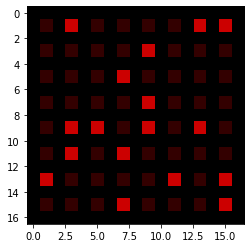

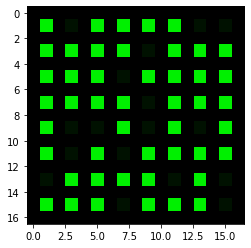

Count: tensor([ 1,  1,  3,  3,  9,  2,  3,  7,  7, 28]) Ratio in this batch: tensor([0.0156, 0.0156, 0.0469, 0.0469, 0.1406, 0.0312, 0.0469, 0.1094, 0.1094,
        0.4375])


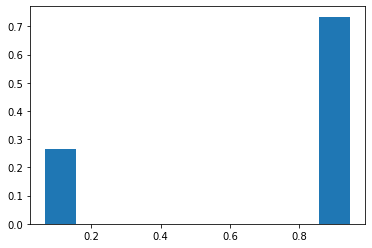

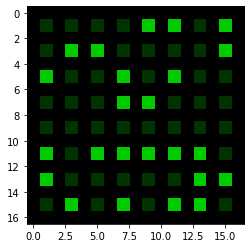

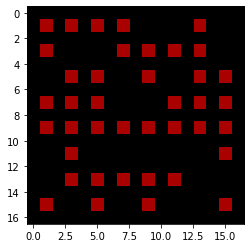

Count: tensor([ 3,  3,  3,  2, 13,  5, 13, 11, 11]) Ratio in this batch: tensor([0.0469, 0.0469, 0.0469, 0.0312, 0.2031, 0.0781, 0.2031, 0.1719, 0.1719])


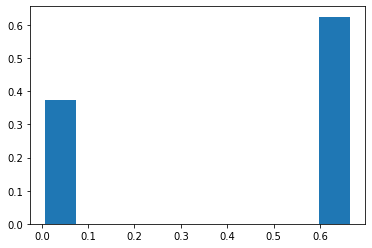

In [12]:
# Some generated images
visualize_img_batch(real_A.detach()[:64])
visualize_img_batch(fake_B.detach()[:64])
plot_hist(fake_B.detach())

visualize_img_batch(real_B.detach()[:64])
visualize_img_batch(fake_A.detach()[:64])
plot_hist(fake_A.detach())

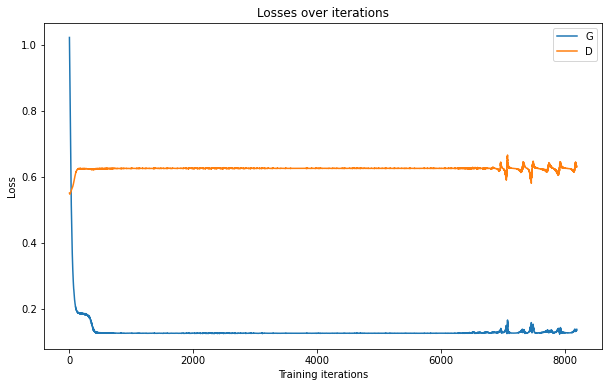

In [13]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(losses_g)
plt.plot(losses_d)
plt.legend(['G', 'D'])
plt.show()

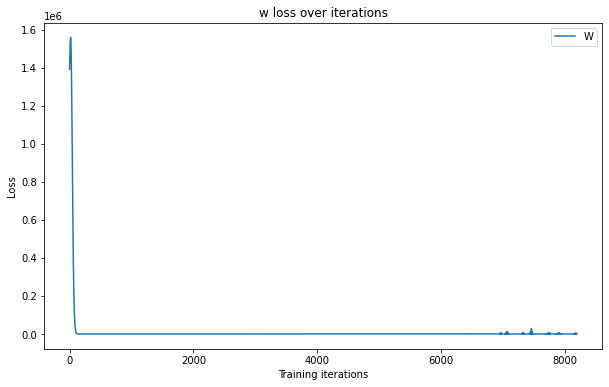

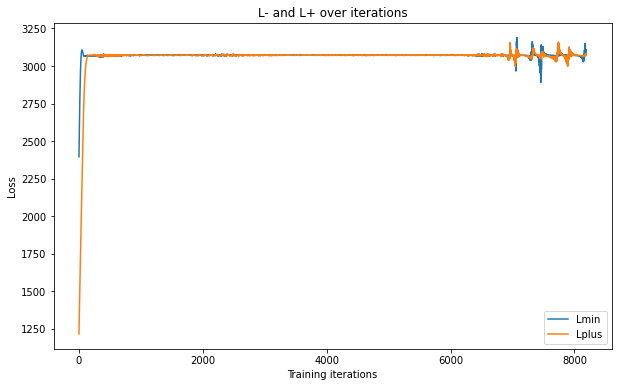

In [14]:
plt.figure(figsize=(10,6))
plt.title('w loss over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(losses_w)
plt.legend(['W'])
plt.show()

plt.figure(figsize=(10,6))
plt.title('L- and L+ over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(Lminusses)
plt.plot(Lplusses)
plt.legend(['Lmin', 'Lplus'])
plt.show()

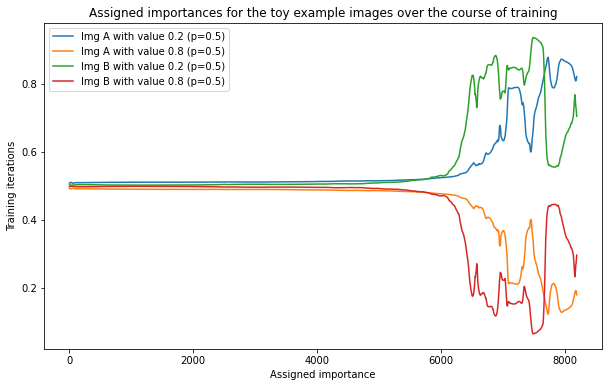

In [15]:
plt.figure(figsize=(10,6))
plt.title('Assigned importances for the toy example images over the course of training')
plt.plot(example_importances_A)
plt.plot(example_importances_B)
plt.legend(['Img A with value {} (p={})'.format(offset_A, ratio_A), 
            'Img A with value {} (p={})'.format(1-offset_A, 1-ratio_A), 
            'Img B with value {} (p={})'.format(offset_B, ratio_B), 
            'Img B with value {} (p={})'.format(1-offset_B, 1-ratio_B)])
plt.xlabel('Assigned importance')
plt.ylabel('Training iterations')
plt.show()

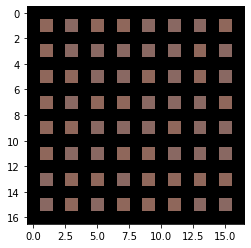

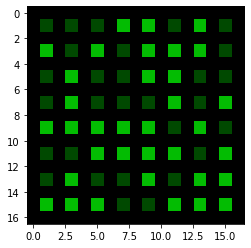

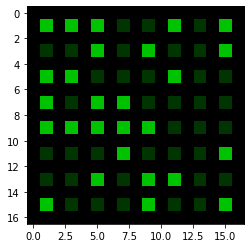

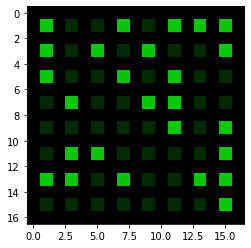

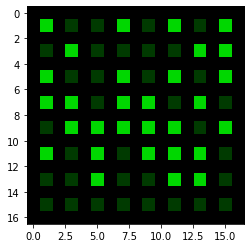

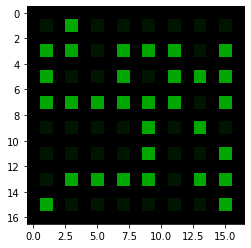

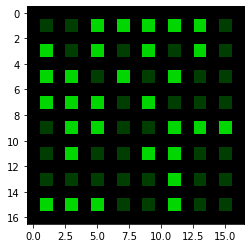

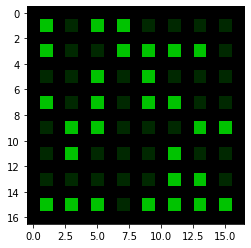

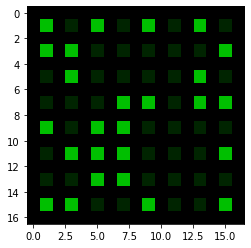

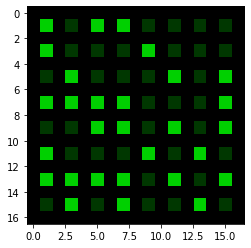

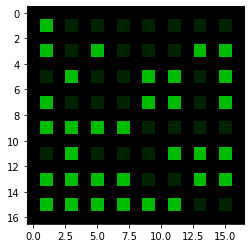

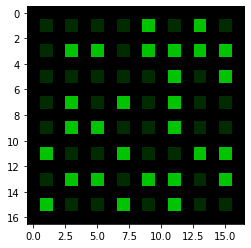

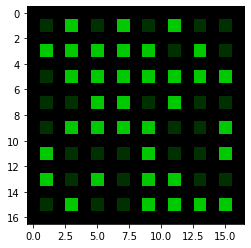

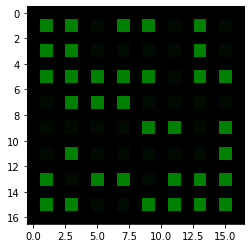

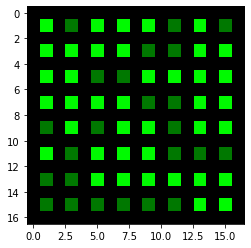

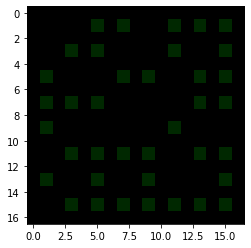

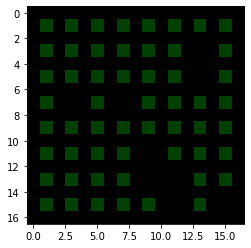

In [16]:
for img in samples_B:
    visualize_img_batch(img[:64])